In [1]:
from sodapy import Socrata
import pandas as pd

In [15]:
with open("secret.txt") as f:
    token = f.read()

In [46]:
# MyAppToken = 'JdK1UvvQNN9ywfsIQJQfJMWLF'
# client = Socrata("data.sfgov.org", None)
client = Socrata("data.sfgov.org", app_token=token)
results = client.get("vw6y-z8j6", \
                     limit=2000, \
#                      select='*', \
#                      where=["service_name='Street and Sidewalk Cleaning' OR service_name='Litter Receptacles'"]\
                    )
# 'Litter Receptacles'
results_df = pd.DataFrame.from_records(results)

In [52]:
results_df['requested_datetime'] = pd.to_datetime(results_df['requested_datetime'])

In [57]:
results_df['hour'] = results_df['requested_datetime'].dt.hour
results_df['minute'] = results_df['requested_datetime'].dt.minute
results_df['day'] = results_df['requested_datetime'].dt.day

In [60]:
results_df

,service_request_id,requested_datetime,updated_datetime,status_description,status_notes,agency_responsible,service_name,service_subtype,service_details,address,...,:@computed_region_viu7_rrfi,:@computed_region_6ezc_tdp2,:@computed_region_h4ep_8xdi,:@computed_region_2dwj_jsy4,closed_date,:@computed_region_y6ts_4iup,hour,minute,day,week
0,16648111,2023-04-09 01:18:14,2023-04-09T03:09:02.000,Open,accepted,Recology_Overflowing,Street and Sidewalk Cleaning,City_garbage_can_overflowing,City_garbage_can_overflowing,"810 CLEMENT ST, SAN FRANCISCO, CA, 94118",...,NaN,NaN,NaN,NaN,NaN,NaN,1,18,9,14
1,16648110,2023-04-09 01:15:14,2023-04-09T01:15:15.000,Open,open,Entertainment Commission - G,Noise Report,entertainment,Noise Report - entertainment,"314 11TH ST, SAN FRANCISCO, CA, 94103",...,NaN,NaN,NaN,NaN,NaN,NaN,1,15,9,14
2,16648109,2023-04-09 01:14:14,2023-04-09T03:08:57.000,Open,closed,Recology_Overflowing,Street and Sidewalk Cleaning,City_garbage_can_overflowing,City_garbage_can_overflowing,Intersection of COLE ST and HAIGHT ST,...,NaN,NaN,NaN,NaN,NaN,NaN,1,14,9,14
3,16648108,2023-04-09 01:12:09,2023-04-09T03:08:54.000,Open,accepted,Recology_Overflowing,Street and Sidewalk Cleaning,City_garbage_can_overflowing,City_garbage_can_overflowing,"401 SUTTER ST, SAN FRANCISCO, CA, 94108",...,NaN,NaN,NaN,NaN,NaN,NaN,1,12,9,14
4,16648107,2023-04-09 01:11:21,2023-04-09T01:30:06.000,Open,accepted,DPT Meter_Bike Queue,Damaged Property,Damaged Parking_Meter,Parking_Meter,"1311 SUTTER ST, SAN FRANCISCO, CA, 94109",...,NaN,NaN,NaN,NaN,NaN,NaN,1,11,9,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,16644888,2023-04-08 02:41:22,2023-04-08T04:10:06.000,Open,accepted,Recology_Overflowing,Street and Sidewalk Cleaning,City_garbage_can_overflowing,City_garbage_can_overflowing,"288 BEACH ST, SAN FRANCISCO, CA, 94133",...,NaN,NaN,NaN,NaN,NaN,NaN,2,41,8,14
1996,16644886,2023-04-08 02:37:22,2023-04-08T17:48:54.000,Closed,Case Resolved - Pickup completed,Recology_Overflowing,Street and Sidewalk Cleaning,City_garbage_can_overflowing,City_garbage_can_overflowing,"3881 CALIFORNIA ST, SAN FRANCISCO, CA, 94118",...,NaN,NaN,NaN,NaN,2023-04-08T17:48:54.000,NaN,2,37,8,14
1997,16644885,2023-04-08 02:37:04,2023-04-08T17:49:58.000,Closed,Case Resolved - Pickup completed,Recology_Overflowing,Street and Sidewalk Cleaning,City_garbage_can_overflowing,City_garbage_can_overflowing,"3400 22ND ST, SAN FRANCISCO, CA, 94110",...,NaN,NaN,NaN,NaN,2023-04-08T17:49:58.000,NaN,2,37,8,14
1998,16644884,2023-04-08 02:35:21,2023-04-08T04:09:55.000,Open,accepted,Recology_Overflowing,Street and Sidewalk Cleaning,City_garbage_can_overflowing,City_garbage_can_overflowing,Intersection of BEACH ST and LARKIN ST,...,NaN,NaN,NaN,NaN,NaN,NaN,2,35,8,14


In [59]:
results_df.keys()

Index(['service_request_id', 'requested_datetime', 'updated_datetime',
       'status_description', 'status_notes', 'agency_responsible',
       'service_name', 'service_subtype', 'service_details', 'address',
       'street', 'supervisor_district', 'neighborhoods_sffind_boundaries',
       'police_district', 'lat', 'long', 'point', 'source',
       ':@computed_region_6qbp_sg9q', ':@computed_region_qgnn_b9vv',
       ':@computed_region_26cr_cadq', ':@computed_region_ajp5_b2md',
       ':@computed_region_rxqg_mtj9', ':@computed_region_yftq_j783',
       ':@computed_region_jx4q_fizf', ':@computed_region_bh8s_q3mv',
       ':@computed_region_p5aj_wyqh', ':@computed_region_fyvs_ahh9',
       ':@computed_region_f58d_8dbm', ':@computed_region_vtsz_7cme',
       ':@computed_region_sruu_94in', ':@computed_region_6pnf_4xz7',
       ':@computed_region_jwn9_ihcz', ':@computed_region_9dfj_4gjx',
       ':@computed_region_4isq_27mq', ':@computed_region_pigm_ib2e',
       ':@computed_region_9jxd_iqe

In [47]:
results_df['service_name'].value_counts()

Street and Sidewalk Cleaning                  990
Parking Enforcement                           320
Graffiti                                      215
Encampments                                    74
General Request - PUBLIC WORKS                 46
Rec and Park Requests                          41
Abandoned Vehicle                              33
General Request - MTA                          28
Tree Maintenance                               27
Sewer Issues                                   26
Damaged Property                               24
Sign Repair                                    23
Litter Receptacles                             18
Street Defects                                 17
Noise Report                                   16
Muni Employee Feedback                         12
Streetlights                                   11
Sidewalk or Curb                               11
Child Request                                  10
Muni Service Feedback                          10


In [48]:
results_df

,service_request_id,requested_datetime,updated_datetime,status_description,status_notes,agency_responsible,service_name,service_subtype,service_details,address,...,media_url,:@computed_region_fcz8_est8,:@computed_region_nqbw_i6c3,:@computed_region_n4xg_c4py,:@computed_region_viu7_rrfi,:@computed_region_6ezc_tdp2,:@computed_region_h4ep_8xdi,:@computed_region_2dwj_jsy4,closed_date,:@computed_region_y6ts_4iup
0,16648111,2023-04-09T01:18:14.000,2023-04-09T03:09:02.000,Open,accepted,Recology_Overflowing,Street and Sidewalk Cleaning,City_garbage_can_overflowing,City_garbage_can_overflowing,"810 CLEMENT ST, SAN FRANCISCO, CA, 94118",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,16648110,2023-04-09T01:15:14.000,2023-04-09T01:15:15.000,Open,open,Entertainment Commission - G,Noise Report,entertainment,Noise Report - entertainment,"314 11TH ST, SAN FRANCISCO, CA, 94103",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,16648109,2023-04-09T01:14:14.000,2023-04-09T03:08:57.000,Open,closed,Recology_Overflowing,Street and Sidewalk Cleaning,City_garbage_can_overflowing,City_garbage_can_overflowing,Intersection of COLE ST and HAIGHT ST,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,16648108,2023-04-09T01:12:09.000,2023-04-09T03:08:54.000,Open,accepted,Recology_Overflowing,Street and Sidewalk Cleaning,City_garbage_can_overflowing,City_garbage_can_overflowing,"401 SUTTER ST, SAN FRANCISCO, CA, 94108",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,16648107,2023-04-09T01:11:21.000,2023-04-09T01:30:06.000,Open,accepted,DPT Meter_Bike Queue,Damaged Property,Damaged Parking_Meter,Parking_Meter,"1311 SUTTER ST, SAN FRANCISCO, CA, 94109",...,{'url': 'https://mobile311.sfgov.org/media/san...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,16644888,2023-04-08T02:41:22.000,2023-04-08T04:10:06.000,Open,accepted,Recology_Overflowing,Street and Sidewalk Cleaning,City_garbage_can_overflowing,City_garbage_can_overflowing,"288 BEACH ST, SAN FRANCISCO, CA, 94133",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996,16644886,2023-04-08T02:37:22.000,2023-04-08T17:48:54.000,Closed,Case Resolved - Pickup completed,Recology_Overflowing,Street and Sidewalk Cleaning,City_garbage_can_overflowing,City_garbage_can_overflowing,"3881 CALIFORNIA ST, SAN FRANCISCO, CA, 94118",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-04-08T17:48:54.000,NaN
1997,16644885,2023-04-08T02:37:04.000,2023-04-08T17:49:58.000,Closed,Case Resolved - Pickup completed,Recology_Overflowing,Street and Sidewalk Cleaning,City_garbage_can_overflowing,City_garbage_can_overflowing,"3400 22ND ST, SAN FRANCISCO, CA, 94110",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-04-08T17:49:58.000,NaN
1998,16644884,2023-04-08T02:35:21.000,2023-04-08T04:09:55.000,Open,accepted,Recology_Overflowing,Street and Sidewalk Cleaning,City_garbage_can_overflowing,City_garbage_can_overflowing,Intersection of BEACH ST and LARKIN ST,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
for key in results_df['service_subtype'].value_counts().keys():
    print(key)

City_garbage_can_overflowing
General Cleaning
Bulky Items
Human or Animal Waste
Parking_on_Sidewalk
Other_Illegal_Parking
Blocking_Driveway_Cite_Only
Encampment Reports
request_for_service
Blocking_Driveway_Cite_Tow
Graffiti on Other_enter_additional_details_below
Graffiti on Building_commercial
Hazardous Materials
Park - Structural_Maintenance
Graffiti on Pole
Graffiti on Signal_box
complaint
Graffiti on Building_residential
Abandoned Vehicles
Pavement_Defect
Sewage_back_up
Medical Waste
Trees - Damaged_Tree
Sign - Defaced
Graffiti on Building_other
Blocking_Bicycle_Lane
Graffiti on Transit_Shelter_Platform
Damaged other
Sign Repair - Missing
Sidewalk_Defect
Water_leak
Toters_left_out_24x7
Graffiti on City_receptacle
Graffiti on Sidewalk_in_front_of_property
Park - Park_Patrol
customer_callback
Damaged Parking_Meter
Transit_shelter_platform
Damaged Traffic_Signal
Park - Neighborhood_Services_Area
Abandoned Vehicle - Car4door
Graffiti on Mail_box
Shared_SpacesObstruction_Hazard
Illegal

In [50]:
results_df['service_subtype'].value_counts()

City_garbage_can_overflowing             407
General Cleaning                         237
Bulky Items                              180
Human or Animal Waste                    117
Parking_on_Sidewalk                       94
                                        ... 
Sign Repair - Bent                         1
Public_Stairway_Defect                     1
Abandoned Vehicle - Other                  1
Manhole_Cover_Off                          1
Missed_TrashRecycleCompost_Collection      1
Name: service_subtype, Length: 119, dtype: int64

In [63]:
full_df = pd.read_csv('311_cases.csv')

In [66]:
ssc_df = full_df[full_df['Category']=='Street and Sidewalk Cleaning']

In [112]:
ssc_df.shape

(2276917, 52)

In [70]:
ssc_df.keys()

Index(['CaseID', 'Opened', 'Closed', 'Updated', 'Status', 'Status Notes',
       'Responsible Agency', 'Category', 'Request Type', 'Request Details',
       'Address', 'Street', 'Supervisor District', 'Neighborhood',
       'Police District', 'Latitude', 'Longitude', 'Point', 'Source',
       'Media URL', 'SF Find Neighborhoods', 'Current Police Districts',
       'Current Supervisor Districts', 'Analysis Neighborhoods',
       'DELETE - Supervisor Districts', 'DELETE - Fire Prevention Districts',
       'DELETE - Current Police Districts', 'DELETE - Zip Codes',
       'DELETE - Police Districts', 'DELETE - Neighborhoods',
       'DELETE - Neighborhoods_from_fyvs_ahh9', 'DELETE - 2017 Fix It Zones',
       'DELETE - SF Find Neighborhoods',
       'Civic Center Harm Reduction Project Boundary',
       'DELETE - Current Supervisor Districts',
       'Fix It Zones as of 2017-11-06 ', 'Invest In Neighborhoods (IIN) Areas',
       'DELETE - HSOC Zones', 'Fix It Zones as of 2018-02-07',
    

In [97]:
ssc_df['Opened'] = pd.to_datetime(ssc_df['Opened'])
ssc_df['hour'] = ssc_df['Opened'].dt.hour
ssc_df['minute'] = ssc_df['Opened'].dt.minute
ssc_df['day'] = ssc_df['Opened'].dt.day
ssc_df['year'] = ssc_df['Opened'].dt.year
ssc_df['Month'] = ssc_df['Opened'].dt.month

/var/folders/5w/82q2gcks59d3npvwjk0xmsm80000gn/T/ipykernel_12591/3052633359.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ssc_df['Opened'] = pd.to_datetime(ssc_df['Opened'])
/var/folders/5w/82q2gcks59d3npvwjk0xmsm80000gn/T/ipykernel_12591/3052633359.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ssc_df['hour'] = ssc_df['Opened'].dt.hour
/var/folders/5w/82q2gcks59d3npvwjk0xmsm80000gn/T/ipykernel_12591/3052633359.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

<AxesSubplot:>

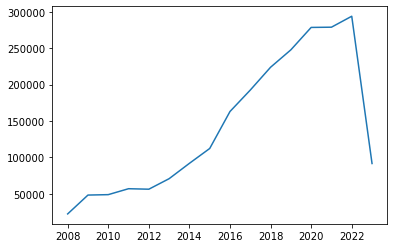

In [103]:
ssc_df['year'].value_counts().sort_index().plot()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

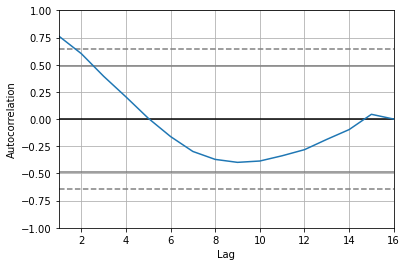

In [111]:
pd.plotting.autocorrelation_plot(ssc_df['year'].value_counts().sort_index())

In [98]:
df_2022 = ssc_df[ssc_df['year']==2022]

<AxesSubplot:>

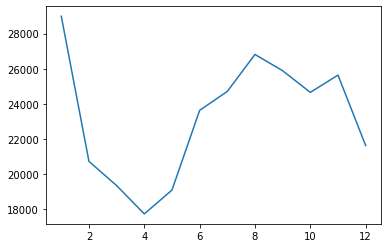

In [100]:
df_2021 = ssc_df[ssc_df['year']==2021]
df_2021['Month'].value_counts().sort_index().plot()

<AxesSubplot:>

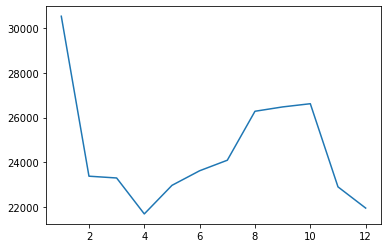

In [99]:
df_2022['Month'].value_counts().sort_index().plot()

/var/folders/5w/82q2gcks59d3npvwjk0xmsm80000gn/T/ipykernel_12591/781699812.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ssc_df['Month'] = ssc_df['Opened'].dt.month


<AxesSubplot:>

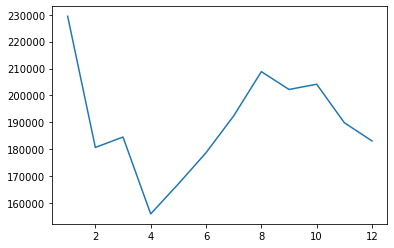

In [96]:
ssc_df['Month'] = ssc_df['Opened'].dt.month
ssc_df['Month'].value_counts().sort_index().plot()

*Models to build:*
 * General volume
 * Garbage can overflowing
 * General cleaning
 * Bulky items
 
*Data Restrictions*
 * Use street cleaning category
 * Years: 2016-present (April 1st, 2023)

*Features to include:*
 * minute
 * day
 * hour
 * hour lags (hours 6-12)
 * ACS census tract data
 